<a href="https://colab.research.google.com/github/NahuelCostaCortez/taller-IA/blob/main/2_EjemploQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown # Descargar librerías necesarias
!pip install langchain
!pip install chromadb
!pip install gradio
!pip install Pillow==9.0.0
!pip install pypdf

  Using cached langchain-0.0.144-py3-none-any.whl (578 kB)
  Using cached tenacity-8.2.2-py3-none-any.whl (24 kB)
  Using cached pydantic-1.10.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached numexpr-2.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (381 kB)
  Using cached dataclasses_json-0.5.7-py3-none-any.whl (25 kB)
  Using cached numpy-1.24.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:0000:01
  Using cached aiohttp-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached openapi_schema_pydantic-1.2.4-py3-none-any.whl (90 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached yarl-1.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (264 kB)
  Using cached frozenlist-1.3.3-cp310-cp310-manylinux_2_5_x86_64.ma

Imports

In [ ]:
import os
from langchain import PromptTemplate, HuggingFaceHub, LLMChain
from langchain.document_loaders import TextLoader, PyPDFLoader

from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.indexes.vectorstore import VectorstoreIndexCreator
from langchain.chains.question_answering import load_qa_chain
from langchain.chains.summarize import load_summarize_chain

import gradio as gr

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Añadir como variable del sistema el API token de HuggingFace

In [ ]:
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""

## PASOS A SEGUIR

**PROCESADO DE DATOS**



> Normalmente los datos provienen de ficheros .txt/.pdf o similar, aunque también se puede ampliar a otras fuentes como tablas de word, ficheros excel, databases de Notion etc etc




Cargar archivo

In [ ]:
file_name = './pdfs/A1-Einstein.pdf' # Cambiar por el nombre del archivo

# cargar archivo
loader = PyPDFLoader(file_name) # pdf loader
# loader = TextLoader(file_name) # txt loader

pages = loader.load_and_split()

pages es un vector en el que cada elemento contiene el texto de una página

In [ ]:
pages[0].page_content

'Todos sabemos quién  fue Albert Einstein y cuáles fueron sus principales \nhallazgos, pero ¿realmente sabemos algo de su biografía o de sus hazañas ?. \n \nFigura mítica de la historia, genio científico, músico y político, Albert Einstein es famoso \npor sus mérit os con la física pero también es conocido como icono del característico \n“científico loco”. La fotografía en la que se muestra al físico sacando la lengua ha dado \nla vuelta al mundo al igual que aquellas de las estrellas de la gran pantalla.  \n \nAl adentrarno s en su biografía descubrimos que nació en la ciudad de Ulm, Alemania, en \n1879. Sus padres, Hermann Einstein y Pauline Koch eran judíos. Albert era un niño quieto \ny ensimismado, cuyo desarrollo intelectual fue bastante lento, lo que determinó, según \nél, la  genialidad en su madurez, porque los fenómenos que no se había cuestionado de \npequeño le vinieron a la mente cuando ya era mayor y le fueron más fáciles de explicar . \n \nEn 1894, su familia se trasladó

dividir las páginas en párrafos

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=0, separator='. \n') # chunk_size: tamaño de cada bloque, separator: separador de bloques
                                                                        # como lo vamos a hacer a nivel de párrafo, el separador es un punto y un salto de línea (punto y aparte)
texts = text_splitter.split_documents(pages)

Created a chunk of size 148, which is longer than the specified 100
Created a chunk of size 798, which is longer than the specified 100
Created a chunk of size 508, which is longer than the specified 100
Created a chunk of size 535, which is longer than the specified 100
Created a chunk of size 219, which is longer than the specified 100
Created a chunk of size 1017, which is longer than the specified 100
Created a chunk of size 644, which is longer than the specified 100


Ahora en texts tenemos todos párrafos del pdf indexados por page_content y metadata

In [ ]:
texts

[Document(page_content='Todos sabemos quién  fue Albert Einstein y cuáles fueron sus principales \nhallazgos, pero ¿realmente sabemos algo de su biografía o de sus hazañas ?', metadata={'source': './pdfs/A1-Einstein.pdf', 'page': 0}),
 Document(page_content='Figura mítica de la historia, genio científico, músico y político, Albert Einstein es famoso \npor sus mérit os con la física pero también es conocido como icono del característico \n“científico loco”. La fotografía en la que se muestra al físico sacando la lengua ha dado \nla vuelta al mundo al igual que aquellas de las estrellas de la gran pantalla.  \n \nAl adentrarno s en su biografía descubrimos que nació en la ciudad de Ulm, Alemania, en \n1879. Sus padres, Hermann Einstein y Pauline Koch eran judíos. Albert era un niño quieto \ny ensimismado, cuyo desarrollo intelectual fue bastante lento, lo que determinó, según \nél, la  genialidad en su madurez, porque los fenómenos que no se había cuestionado de \npequeño le vinieron a l

De texts solo queremos el texto -> extraemos la parte de page_content de cada texto

In [ ]:
texts = [str(i.page_content) for i in texts]

In [ ]:
texts

['Todos sabemos quién  fue Albert Einstein y cuáles fueron sus principales \nhallazgos, pero ¿realmente sabemos algo de su biografía o de sus hazañas ?',
 'Figura mítica de la historia, genio científico, músico y político, Albert Einstein es famoso \npor sus mérit os con la física pero también es conocido como icono del característico \n“científico loco”. La fotografía en la que se muestra al físico sacando la lengua ha dado \nla vuelta al mundo al igual que aquellas de las estrellas de la gran pantalla.  \n \nAl adentrarno s en su biografía descubrimos que nació en la ciudad de Ulm, Alemania, en \n1879. Sus padres, Hermann Einstein y Pauline Koch eran judíos. Albert era un niño quieto \ny ensimismado, cuyo desarrollo intelectual fue bastante lento, lo que determinó, según \nél, la  genialidad en su madurez, porque los fenómenos que no se había cuestionado de \npequeño le vinieron a la mente cuando ya era mayor y le fueron más fáciles de explicar',
 'En 1894, su familia se trasladó a M

**BUSCAR TEXTO QUE PUEDA CONTENER LA RESPUESTA A LA CONSULTA DADA**



> La lógica que se sigue para cuando se tienen varios pdfs/documentos es la siguiente
1. Se obtiene una representación numérica donde textos similares estén en zonas similares en un espacio multidimensional (embeddings) -> [ejemplo visualización embeddings](https://projector.tensorflow.org/)
2. Se busca en ese espacio multidimensional qué documentos son similares a la pregunta planteada (y que por tanto pueden contener la respuesta)




In [ ]:
question = "en qué año se trasladó a Milán?"

docsearch = Chroma.from_texts(texts, metadatas=[{"source": str(i)} for i in range(len(texts))]).as_retriever()
docs = docsearch.get_relevant_documents(question)

Using embedded DuckDB without persistence: data will be transient
No embedding_function provided, using default embedding function: SentenceTransformerEmbeddingFunction




> Nota: en este ejemplo se utilizan los embeddings por defecto. Sin embargo, los embeddings de openAI proporcionan mejores resultados, con el inconveniente que se ofrecen a través de su api y no son gratuitos ([aunque sí muy baratos](https://openai.com/pricing)).


> En el caso de tener una API key de openAI la anterior función se utilizaría de la siguiente manera:


```
os.environ["OPENAI_API_TOKEN"] = "..." # insertar API key
from langchain.embeddings.openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()
docsearch = Chroma.from_texts(texts, embeddings, metadatas=[{"source": str(i)} for i in range(len(texts))]).as_retriever()
```






Se puede ver que docs no es todo el texto que teníamos antes si no que se han filtrado algunos párrafos. Los "Documents" están ordenados de mayor a menor similitud respecto a la pregunta planteada

In [ ]:
docs

[Document(page_content='En 1894, su familia se trasladó a Milán por dificultades económicas pero él permaneció  \nen Munich para terminar sus estudios secundarios. Se reunió con sus padres y su \nhermana al año siguiente. Realizó sus estudios superiores en la Eidgenossische \nTechnische Hochsule de Zurich, donde fue alumno del matemático Hermann Minkowski.  \n Trabajando e ntre 1902 y 1909 en la Oficina Confederal de la Propiedad Intelectual de \nBerna, contrajo matrimonio con Mileva Maric, antigua compañera de estudios en Zurich', metadata={'source': '2'}),
 Document(page_content='Claves: El británico vive en la casa roja, El sueco tiene como mascota un perro, El danés toma te, la casa verde \nestá a la izquierda de la casa blanca, el dueño de la casa verde toma café, la persona que fuma Pall Mall tiene un \npájaro, el dueño de la casa amarilla  fuma Dunhill, el que vive en la casa del centro toma leche, el noruego vive en \nla primera casa, la persona que fuma Blends vive junto a la 

**CARGAR MODELO A UTILIZAR**


> Algunos modelos del estado del arte son:


> - OpenAssistant/oasst-sft-1-pythia-12b
> - OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5
> - google/flan-t5-xl
> - bigscience/bloom


> Si se desea utilizar otro modelo se puede buscar directamente en el [hub de HuggingFace](https://huggingface.co/models). El nombre (repo_id) se copia directamente de la parte superior.


> Ejemplo para BLOOM:




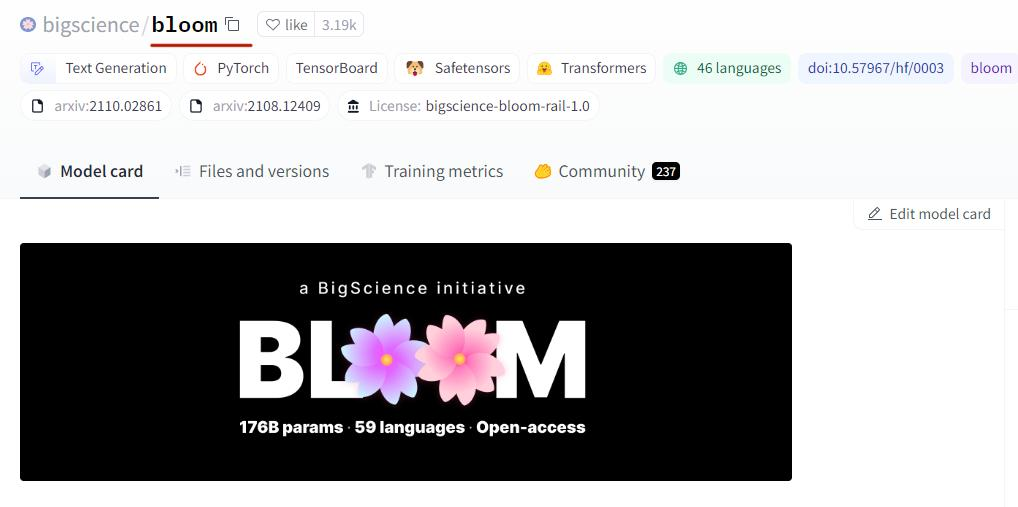



In [ ]:
model = HuggingFaceHub(repo_id="google/flan-t5-xl", model_kwargs={"temperature":1e-10}) # temperature permite aumentar o disminuir la "confianza" que tiene el modelo en sus respuestas

**RETORNAR RESPUESTA**



> 0. Opcionalmente se puede proporcionar más información al modelo para que responda según nuestras preferencias -> pre-prompt
1.Se crea un pipeline para pasar los documentos y la pregunta
2.  Se ejecuta la consulta



In [ ]:
pre_prompt = """Utiliza el siguiente contexto para responder a la pregunta del final. Si no sabes la respuesta, di simplemente que no la sabes, no intentes inventarte una respuesta.

{context}

Pregunta: {question}
Respuesta:"""

PROMPT = PromptTemplate(
    template=pre_prompt, input_variables=["context", "question"]
)

pipeline = load_qa_chain(model, chain_type="stuff", prompt=PROMPT)
answer = pipeline({"input_documents": docs, "question": question}, return_only_outputs=True)

In [ ]:
answer['output_text']

'1894'

## Juntando todo

Si juntamos todos los pasos podemos agruparlos en funciones de tal manera que dejemos como parámetros solo las cosas que queramos cambiar. Por ejemplo:

- Modelo
- Temperature
- Pre-prompt
- Pregunta

In [ ]:
def extract_text_from_pdf(pdf_file):
    loader = PyPDFLoader(pdf_file)
    pages = loader.load_and_split()
    text_splitter = CharacterTextSplitter(chunk_size=1000, separator='.\n')
    texts = text_splitter.split_documents(pages)
    texts = [str(i.page_content) for i in texts]
    return texts

def load_model(model_name, temperature):
    return HuggingFaceHub(repo_id=model_name, model_kwargs={"temperature":temperature})

def predict(text, model, pre_prompt, question):
    docsearch = Chroma.from_texts(text, metadatas=[{"source": str(i)} for i in range(len(text))]).as_retriever()
    docs = docsearch.get_relevant_documents(question)
    PROMPT = PromptTemplate(
    template=pre_prompt, input_variables=["context", "question"]
    )
    pipeline = load_qa_chain(model, chain_type="stuff", prompt=PROMPT)
    answer = pipeline({"input_documents": docs, "question": question}, return_only_outputs=True)
    return answer['output_text']

def get_answer(file_name, model_name, temperature, pre_prompt, question):
  text = extract_text_from_pdf(file_name)
  model = load_model(model_name, temperature)
  answer = predict(text, model, pre_prompt, question)
  return answer

In [ ]:
file_name = './pdfs/Jetson_Nano_Developer_Kit_User_Guide.pdf'
model_name = "google/flan-t5-xl"
temperature = 1e-10
pre_prompt = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Answer:"""
question = "What is NVIDIA Jetson Nano Developer Kit?"

In [ ]:
get_answer(file_name, model_name, temperature, pre_prompt, question)

Using embedded DuckDB without persistence: data will be transient
No embedding_function provided, using default embedding function: SentenceTransformerEmbeddingFunction


'an AI computer for makers, learners, and developers'

Using embedded DuckDB without persistence: data will be transient
No embedding_function provided, using default embedding function: SentenceTransformerEmbeddingFunction


## Interfaz de usuario

In [ ]:
# aquí no proporcionamos ni file_name ni question porque se extraería del pdf cargado y del campo "Pregunta" de la interfaz
model_name = "google/flan-t5-xl"
temperature = 1e-10
pre_prompt = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Answer:"""

In [ ]:
def get_pdf_text_and_predict(pdf_file, question):
    answer = get_answer(pdf_file.name, model_name, temperature, pre_prompt, question)
    return answer

# Componente de entrada -> carga pdf
file_upload = gr.File()

# Componente de entrada -> introducción de texto
text_input = gr.Textbox(label="Pregunta:")

# Componente de salida -> para mostrar la respuesta del modelo
output_text = gr.Textbox(label="Respuesta del modelo")

# Definir la interfaz
interface = gr.Interface(
    inputs=[file_upload, text_input], # inputs
    outputs=output_text, # outputs
    fn=get_pdf_text_and_predict, # función a ejecutar al presionar "Enviar"
    title="PDF QA Demo",
    description="Carga un PDF, el modelo tratará de responder cualquier pregunta que le hagas acerca de su contenido.",
    theme="default"
)

# Ejecutar la interfaz
interface.launch()

Sagemaker notebooks may require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://d47fac1a85ed8d1d83.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Using embedded DuckDB without persistence: data will be transient
No embedding_function provided, using default embedding function: SentenceTransformerEmbeddingFunction
Using embedded DuckDB without persistence: data will be transient
No embedding_function provided, using default embedding function: SentenceTransformerEmbeddingFunction


## Tareas propuestas

Modificar:
- Documentos
- Modelos
- Pre-prompts
- Explorar más [casos de uso](https://python.langchain.com/en/latest/modules/chains/how_to_guides.html)